### Initialize Libaries, Data, & Structures

In [1]:
# load libaries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.api import OLS, add_constant
import pandas as pd
import numpy as np

In [2]:
# load data
d = pd.read_csv('data-clean.csv', low_memory=False)
exclude_df = pd.read_csv('data-exclude.csv')
ff3 = pd.read_csv('ff3-clean.csv')

# adj Fama-French factors to reflect RET lag
ff3cols = ['Mkt-RF','SMB','HML']
ff3[ff3cols] = ff3[ff3cols].apply(lambda x: x.shift(-1))

# adjust price to cap at $15
d['PRC'] = np.where(d['PRC'] >= 15, 15, d['PRC'])
exclude_df['PRC'] = np.where(exclude_df['PRC'] >= 15, 15, exclude_df['PRC'])

# define constants & structures
y_col = 'financialDistress_12_periods'
rf = ff3[['date_month','RF']] # isolate rf rate to merge with main dataset
rf['RF-shifted'] = rf['RF'].shift(-1)

# reset dates to datetime
d['year'] = pd.to_datetime(d['date_month']).dt.to_period('Y')
d['date_month'] = pd.to_datetime(d['date_month']).dt.to_period('M')
exclude_df['year'] = pd.to_datetime(exclude_df['date_month']).dt.to_period('Y')
exclude_df['date_month'] = pd.to_datetime(exclude_df['date_month']).dt.to_period('M')
rf['date_month'] = pd.to_datetime(rf['date_month']).dt.to_period('M')
ff3['date_month'] = pd.to_datetime(ff3['date_month']).dt.to_period('M')

C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\shanc\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
# load data
text = pd.read_csv('data-clean-text.csv', low_memory=False)
exclude_text = pd.read_csv('data-exclude-text.csv', low_memory=False)

# adjust price to cap at $15
text['PRC'] = np.where(text['PRC'] >= 15, 15, text['PRC'])
exclude_text['PRC'] = np.where(exclude_text['PRC'] >= 15, 15, exclude_text['PRC'])

# reset dates to datetime
text['year'] = pd.to_datetime(text['date_month']).dt.to_period('Y')
text['date_month'] = pd.to_datetime(text['date_month']).dt.to_period('M')
exclude_text['year'] = pd.to_datetime(exclude_text['date_month']).dt.to_period('Y')
exclude_text['date_month'] = pd.to_datetime(exclude_text['date_month']).dt.to_period('M')

### Back Test Functions

In [4]:
# define backtest class
class strategy:
    # define portfolio build loop function as init
    def __init__(self, df, start, end, cols=True, model='L'):
        # run build for first time
        self.bin_data, self.coefs, self.years = build_ports(df, start, end, cols=cols, model=model)
        self.data, self.start, self.end, self.model = df, start, end, model
        if cols: self.cols = ['NITA','TLTA','CASHMTA','EXRET','RSIZE','PRC','SIGMA','SIGMA_TLTA']
        else: self.cols = cols
            
    # define build ports function for later iterations
    def build_ports(self, df, start, end, cols=True, model='L'):
        # run later build
        self.bin_data, self.coefs, self.years = build_ports(df, start, end, cols=cols, model=model)
        self.data, self.start, self.end, self.model = df, start, end, model
        if cols: self.cols = ['NITA','TLTA','CASHMTA','EXRET','RSIZE','PRC','SIGMA','SIGMA_TLTA']
        else: self.cols = cols
        
    def weight_returns(self, value=True):
        self.ports = weight_returns(self.bin_data, self.years, value=value)
        self.value = value
        print('Returns Weighted')
        
    def compile_ports(self):
        self.main, self.returns_table = compile_ports(self.ports)
        print('Portfolios Compiled')
    
    def test(self):
        self.alphas, F, self.betas = test(self.ports, self.years)
        name = str(self.start) + '-' + str(self.end)
        self.F = F.rename(index={0:name})

In [5]:
def build_ports(df, start, end, cols=True, model='L'):
    # define constants & structures
    years = pd.Series(df['year'].unique()).sort_values().reset_index(drop=True)
    if cols == True: cols = ['NITA','TLTA','CASHMTA','EXRET','RSIZE','PRC','SIGMA','SIGMA_TLTA'] # 'NIMTA', 'TLMTA'
    else: cols = cols
    p3 = pd.DataFrame()
    coefs = pd.DataFrame()

    # isolate target years (inclusive of start, end years)
    try: y = years.apply(lambda x: int(x.strftime('%Y'))) # convert years from str to int
    except: y = years # handle if already int
    y = y[y >= start]
    y = y[y <= end]
    years = years[y.index].reset_index(drop=True)

    # main backtest loop
    for year in years:
        # isolate month-firms for train and test
        p = df[df['year'] == year].reset_index(drop=True)
        months = pd.Series(p['date_month'].unique()).sort_values().reset_index(drop=True)

        # get probs & exclude by month
        for month in months:
            o = df[df['date_month'] < (month-12)].reset_index(drop=True) # no forwad looking info (y_col)
            p2 = p[p['date_month'] == month].reset_index(drop=True)

            # split into X, y & scale X
            X, X2, y = o[cols], p2[cols], o[y_col]
            sclr = StandardScaler()
            X = sclr.fit_transform(X)
            X2 = sclr.transform(X2)

            # model data and get bankruptcy probability
            try:
                if model == 'L': mdl = LogisticRegression(random_state=10, max_iter=10000)
                elif model == 'R': mdl = RandomForestClassifier(criterion='entropy', n_estimators=15, max_depth=8, random_state=10)
                mdl.fit(X, y)
                p2['Prob'] = pd.DataFrame(mdl.predict_proba(X2))[1]

                # save feature coef/importance
                temp_cols_name = str(month)
                if model == 'L': coefs[temp_cols_name] = pd.Series(mdl.coef_[0])
                elif model == 'R': coefs[temp_cols_name] = pd.Series(mdl.feature_importances_)
            except:
                print('Model Failed', month)
                continue

            # assign to bins
            try: p2['bin'] = pd.qcut(p2['Prob'],10,labels=list(range(1,11))) # deciles
            except: print('Binning Failed', month)
            p3 = p3.append(p2) # save component data
        print('Portfolio Build Success', year)

    # post-build organization
    coefs['Coef'] = cols
    coefs = coefs.set_index('Coef')
    return p3, coefs, years

In [6]:
def weight_returns(bin_data, years, value=True):
    # weight portfolios to build portfolio returns w/ monthly period
    ports = pd.DataFrame()
    for year in years:
        p3 = bin_data[bin_data['year'] == year]
        for i in range(1,11):
            dec = p3[p3['bin'] == i]
            mrk_mon = dec.groupby(['date_month'])['MKTCAP'].sum() # get total market cap for bin
            merge = dec.merge(mrk_mon,left_on='date_month',right_on='date_month')
            merge['weight'] = merge['MKTCAP_x']/merge['MKTCAP_y'] # get value-weight
            merge['w_ret'] = merge['weight']*merge['RET-shifted']
            if value: # value-weight returns
                dec = pd.DataFrame(merge.groupby('date_month')['w_ret'].sum())
                dec = dec.reset_index().rename(columns={'w_ret':'return'})
            else: # equal-weight returns
                dec = pd.DataFrame(merge.groupby('date_month')['RET-shifted'].mean())
                dec = dec.reset_index().rename(columns={'RET-shifted':'return'})

            # calc & merge mean probability & risk-free rate
            mean = merge.groupby('date_month')['Prob'].mean().reset_index()
            dec = dec.merge(mean, on='date_month')
            dec = dec.merge(rf, on='date_month')

            # add other features
            dec['premium'] = dec['return'] - dec['RF-shifted']
            dec['year'] = year
            dec['bin'] = i
            ports = ports.append(dec) # append to masterlist

    # save portfolio returns to object
    ports = ports.reset_index(drop=True)
    return ports

In [7]:
# define portfolio compilation function
def compile_ports(ports):
    
    # seperate by bin & calc std
    t = pd.DataFrame()
    for b in range(1,11):
        t[b] = ports[ports['bin'] == b]['return'].reset_index(drop=True)
    t['date'] = ports['date_month'].unique()    
    t = t.set_index('date', drop=True)
    std = t.apply(np.std)

    # annualize values
    std = std*(12**0.5)
    year_premium = (1+ports.groupby(['bin','year'])[['premium']].mean())**12 - 1
    year_return = (1+ports.groupby(['bin','year'])[['return']].mean())**12 - 1
    
    # get main performance metrics
    main = year_return.groupby(['bin'])[['return']].mean()
    main['premium'] = year_premium.groupby(['bin'])[['premium']].mean()
    nyears = len(ports['year'].unique())
    #main['1$'] = (1+main['return'])**(nyears)
    main['premium'] = main['premium'].map(lambda x: str(round(x*100,2)) + '%')
    main['return'] = main['return'].map(lambda x: str(round(x*100,2)) + '%')
    main['prob'] = ports.groupby(['bin'])['Prob'].mean().apply(lambda x: str(round(x*100,3)) + '%')
    main['risk'] = std.apply(lambda x: str(round(x*100, 2)) + '%')
    main['Sharpe'] = main['premium'].apply(lambda x: float(x[:-1])/100)/std
    main = main.T
    
    return main, t

In [8]:
# define portfolio testing function
def port_tests(b, df):

    # step 4: test agains fama-franch (t & F-tests)
    port = df[df['bin'] == b]
    port = port.merge(ff3, on='date_month')
    
    # run regression
    X = port[['Mkt-RF','SMB','HML']]
    y = port['premium']
    
    # run regression
    X = add_constant(X)
    ols = OLS(y.values, X)
    ols = ols.fit()
    pred = ols.predict()
    resid = y - pred
    
    # organize results & get r2
    out = pd.DataFrame(ols.summary2().tables[1][0:1][['Coef.','t']])
    out = out.rename(columns={'Coef.':'alpha','t':'t-stat'}).reset_index(drop=True)
    out['R2'] = pd.Series(ols.summary2().tables[0][1][6])[0]
    out['Mkt-RF Beta'] = pd.Series(ols.summary2().tables[1][1:2]['Coef.'])[0]
    out['Mkt-RF t'] = (out['Mkt-RF Beta'] - 1)/pd.Series(ols.summary2().tables[1][1:2]['Std.Err.'])[0]
    out['SMB Beta'] = pd.Series(ols.summary2().tables[1][2:3]['Coef.'])[0]
    out['SMB t'] = (out['SMB Beta'] - 1)/pd.Series(ols.summary2().tables[1][2:3]['Std.Err.'])[0]
    out['HML Beta'] = pd.Series(ols.summary2().tables[1][3:4]['Coef.'])[0]
    out['HML t'] = (out['HML Beta'] - 1)/pd.Series(ols.summary2().tables[1][3:4]['Std.Err.'])[0]
    out['bin'] = b
    #out['model'] = ols

    return resid, out

In [9]:
# define function for high-low t-test
def high_low(df):
    
    # setup high-low
    high = df[df['bin'] == 1].reset_index(drop=True)
    low = df[df['bin'] == 10].reset_index(drop=True)
    high = high.merge(ff3, on='date_month')
    
    # run regression
    X_high = high[['Mkt-RF','SMB','HML']]
    y_high = high['premium'] - low['premium']

    # run regression
    X_high = add_constant(X_high)
    hi = OLS(y_high.values, X_high)
    hi = hi.fit()
    
    # output metrics
    out = pd.DataFrame(hi.summary2().tables[1][0:1][['Coef.','t']])
    out['R2'] = pd.Series(hi.summary2().tables[0][1][6])[0]
    out = out.T.rename(index={'Coef.':'alpha','t':'t-stat','Unnamed 0':'R2'}, columns={'const':'High-Low'}).T
    out['Mkt-RF Beta'] = pd.Series(hi.summary2().tables[1][1:2]['Coef.'])[0]
    out['Mkt-RF t'] =  (out['Mkt-RF Beta'] - 1)/pd.Series(hi.summary2().tables[1][1:2]['Std.Err.'])[0]
    out['SMB Beta'] = pd.Series(hi.summary2().tables[1][2:3]['Coef.'])[0]
    out['SMB t'] = (out['SMB Beta'] - 1)/pd.Series(hi.summary2().tables[1][2:3]['Std.Err.'])[0]
    out['HML Beta'] = pd.Series(hi.summary2().tables[1][3:4]['Coef.'])[0]
    out['HML t'] = (out['HML Beta'] - 1)/pd.Series(hi.summary2().tables[1][3:4]['Std.Err.'])[0]
    #out['model'] = hi
     
    return out.T

In [10]:
# Define F-test function
def F_test(alpha_hat, resids, F):
    
    # calulate formula inputs
    mu_bar = F.apply(np.mean) # sample means of factors
    T = resids.shape[0] # get periods T (months)
    N = alpha_hat.shape[0] # get portfolios (bins)
    L = mu_bar.shape[0] # get factors count (feature cols)
    sigma_hat = resids.cov()*(T/(T-L-1)) # residual covar matrix
    omega_hat = F.cov()*(T/(T-1)) # factor covar matrix
    aSa = alpha_hat.T @ np.linalg.inv(sigma_hat) @ alpha_hat
    mOm = mu_bar.T @ np.linalg.inv(omega_hat) @ mu_bar
    
    # execute F-test calc
    F = (T/N)*((T-N-L)/(T-L-1))*(aSa/(1+mOm))
    
    # absolut mean of alphas
    alpha_mean = np.mean(abs(alpha_hat))
    
    # build output df
    F_table = pd.DataFrame([T,F,alpha_mean],index=['Months','F-Stat','Avg |alpha|']).T
    
    return F_table

In [11]:
# define unified test function
def test(ports, years):
    
    # define f_mat for length calcs
    try: F_mat = ff3[ff3['year'].isin(list(years.dt.year))][['Mkt-RF','SMB','HML']]
    except: F_mat = ff3[ff3['year'].isin(years)][['Mkt-RF','SMB','HML']]
    l = F_mat.shape[0]
    
    # test portfolios against Fama-French 3 Factor
    alphas = pd.DataFrame()
    resids = pd.DataFrame(np.zeros((l,10)),columns=list(range(1,11)))
    for i in range(1,11):
        resid, out = port_tests(i, ports)
        alphas = alphas.append(out).reset_index(drop=True)
        resids[i] = resid
    print('Test Success')

    # run F-test
    alpha_hat = alphas['alpha'] # estimated intercepts
    F = F_test(alpha_hat, resids, F_mat)
    R2 = alphas['R2'].map(float)
    F['Avg R-2'] = np.mean(R2.values)
    print('F Success')

    # get hgih-low t-test results
    out = high_low(ports)

    # adjust final alpha df
    alphas = alphas.set_index('bin')
    alphas = alphas.append(out.T)
    alphas = alphas.T
    print('Back Test Success')
        
    # betas jic
    betas = True
    
    return alphas.T, F, betas

### Portfolio Loop Function

In [12]:
# define back test function
def backtest(df, start=1975, end=2018, cols=True, model='L', value=True):
    # initial object and run through functions
    m = strategy(df, start=start, end=end, cols=cols, model=model)
    m.weight_returns(value=value)
    m.compile_ports()
    m.test()
    return m

In [148]:
cols = ['PRC','TLTA','FinTerms_Litigious','FinTerms_Positive','SIGMA_TLTA','FinTerms_ModalWeak_count',
        'SIGMA','FinTerms_Litigious_count','FinTerms_Negative','FinTerms_ModalWeak',
        'FinTerms_ModalStrong','CASHMTA','NITA','EXRET','averageWordsPerParagraph']
#m1 = backtest(text, start=1997, end=2018, value=True, cols=cols)
#m2 = backtest(exclude_text, start=1997, end=2018, value=True, cols=cols)

Portfolio Build Success 1997
Portfolio Build Success 1998
Portfolio Build Success 1999
Portfolio Build Success 2000
Returns Weighted
Portfolios Compiled
Test Success
F Success
Back Test Success


In [143]:
m1.main

bin,1,2,3,4,5,6,7,8,9,10
return,11.0%,22.42%,24.11%,19.26%,20.88%,17.96%,8.22%,7.55%,12.36%,14.78%
premium,5.6%,16.53%,18.16%,13.52%,15.02%,12.22%,2.94%,2.31%,6.95%,9.16%
prob,0.193%,0.25%,0.291%,0.367%,0.572%,0.992%,1.627%,2.509%,3.897%,12.072%
risk,16.58%,16.76%,23.42%,30.96%,29.56%,31.03%,35.95%,39.92%,51.67%,58.47%
Sharpe,0.337792,0.986443,0.775363,0.436747,0.508137,0.393854,0.0817785,0.0578614,0.134499,0.156655


### Back Tests

#### Full Range

In [200]:
#ports = backtest(d, start=1975, end=2018)
print(ports.F)
ports.main.T[['return','prob','risk','Sharpe']].T
#ports.alphas.T#[['alpha','t-stat','R2','Mkt-RF Beta','SMB Beta','HML Beta']]

           Months    F-Stat  Avg |alpha|  Avg R-2
1975-2018   528.0  2.857314     0.004558   0.7995


bin,1,2,3,4,5,6,7,8,9,10
return,13.59%,15.93%,15.93%,16.33%,15.61%,15.42%,15.31%,17.92%,18.67%,22.37%
prob,0.051%,0.087%,0.12%,0.165%,0.255%,0.431%,0.737%,1.248%,2.192%,7.787%
risk,14.35%,18.7%,21.17%,23.17%,24.75%,26.19%,28.08%,30.6%,33.08%,38.79%
Sharpe,0.603974,0.585481,0.516657,0.490315,0.431995,0.403187,0.375737,0.433052,0.421744,0.449311


In [199]:
#ex_ports = backtest(exclude_df, start=1975, end=2018)
print(ex_ports.F)
ex_ports.main.T[['return','prob','risk','Sharpe']].T
#ex_ports.alphas.T

           Months    F-Stat  Avg |alpha|  Avg R-2
1975-2018   528.0  3.919074     0.005055     0.79


bin,1,2,3,4,5,6,7,8,9,10
return,20.01%,19.07%,19.02%,17.69%,15.98%,16.55%,16.66%,18.22%,17.52%,26.79%
prob,0.088%,0.121%,0.179%,0.288%,0.47%,0.744%,1.142%,1.742%,2.827%,9.522%
risk,18.21%,21.06%,23.7%,24.61%,25.98%,27.9%,29.86%,31.96%,34.46%,41.57%
Sharpe,0.80952,0.66249,0.586059,0.515175,0.426133,0.419776,0.399923,0.421492,0.370246,0.522471


#### ML Portfolio

In [198]:
#rf_ports = backtest(d, start=1983, end=2018, model='R')
print(rf_ports.F)
rf_ports.main.T[['return','prob','risk','Sharpe']].T
#rf_ports.alphas.T

           Months    F-Stat  Avg |alpha|  Avg R-2
1983-2018   432.0  4.200216     0.005576   0.8004


bin,1,2,3,4,5,6,7,8,9,10
return,13.22%,14.51%,14.25%,12.6%,14.97%,11.57%,11.52%,7.61%,8.79%,15.66%
prob,0.079%,0.135%,0.177%,0.226%,0.288%,0.393%,0.621%,1.17%,2.594%,10.396%
risk,13.32%,16.82%,18.78%,20.28%,23.3%,26.55%,28.9%,30.54%,33.66%,42.0%
Sharpe,0.6944,0.62492,0.549104,0.430922,0.47344,0.291495,0.270625,0.13295,0.159855,0.291634


In [27]:
#rf_ex_ports = backtest(exclude_df, start=1983, end=2018, model='R')
print(rf_ex_ports.F)
rf_ex_ports.main.T[['return','prob','risk','Sharpe']].T
#rf_ex_ports.alphas.T

           Months   F-Stat  Avg |alpha|  Avg R-2
1983-2018   432.0  5.09221     0.007203   0.8157


bin,1,2,3,4,5,6,7,8,9,10
return,19.57%,17.06%,17.07%,14.54%,10.18%,10.18%,9.82%,10.18%,9.22%,14.75%
prob,0.141%,0.181%,0.225%,0.289%,0.401%,0.611%,1.024%,1.841%,3.675%,12.579%
risk,16.48%,18.03%,19.96%,22.4%,24.67%,27.52%,30.69%,33.27%,36.5%,45.7%
Sharpe,0.937533,0.723187,0.654711,0.477608,0.262291,0.237679,0.204306,0.203185,0.161922,0.251194


In [196]:
#rf_ex_ports2 = backtest(exclude_df, start=1997, end=2018, model='R')
#print(rf_ex_ports2.alphas.T)
print('Baseline Excluded RF Portfolio')
print(rf_ex_ports2.F)
rf_ex_ports2.main.T[['return','prob','risk','Sharpe']].T

           Months    F-Stat  Avg |alpha|  Avg R-2
1997-2018   264.0  3.298836     0.006012   0.8229


bin,1,2,3,4,5,6,7,8,9,10
return,17.34%,16.47%,17.29%,16.22%,10.59%,12.8%,14.51%,16.97%,19.79%,29.5%
prob,0.205%,0.254%,0.308%,0.387%,0.522%,0.778%,1.286%,2.275%,4.462%,14.443%
risk,16.99%,18.31%,20.72%,24.11%,27.13%,30.73%,35.45%,38.2%,42.68%,53.64%
Sharpe,0.888744,0.776464,0.725784,0.582392,0.314441,0.348803,0.352279,0.392174,0.416401,0.512666


#### Text

In [ ]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA',
        'FinTerms_Litigious','FinTerms_Positive','FinTerms_ModalWeak','FinTerms_Litigious_count',
        'FinTerms_ModalStrong','averageWordsPerParagraph','FinTerms_ModalStrong_count']
#tx_ports = backtest(text, start=1997, end=2018, cols=cols)
#tx_ex_ports = backtest(exclude_text, start=1997, end=2018, cols=cols)
#tx_rf_ex_ports = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')

In [ ]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','FinTerms_Litigious']
#tx_rf_ports_lit = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print('Litigious Excluded RF Portfolio')
print(tx_rf_ports_lit.F)
tx_rf_ports_lit.main.T[['return','prob','risk','Sharpe']].T
#tx_rf_ports_lit.alphas

In [ ]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','FinTerms_Positive'] 
#tx_rf_ports_pos = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print('Positive Excluded RF Portfolio')
print(tx_rf_ports_pos.F)
tx_rf_ports_pos.main.T[['return','prob','risk','Sharpe']].T
#tx_rf_ports_pos.alphas

In [ ]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','FinTerms_ModalStrong_count'] 
#tx_rf_ports_count = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print('Strong Count Excluded RF Portfolio')
print(tx_rf_ports_count.F)
tx_rf_ports_count.main.T[['return','prob','risk','Sharpe']].T
#tx_rf_ports_count.alphas

In [21]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','FinTerms_ModalStrong'] 
#tx_rf_ports_strong = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print(tx_rf_ports_strong.F)
tx_rf_ports_strong.main.T[['return','prob','risk','Sharpe']].T

           Months    F-Stat  Avg |alpha|  Avg R-2
1997-2018   264.0  1.939593     0.004755   0.8358


bin,1,2,3,4,5,6,7,8,9,10
return,15.02%,17.19%,15.12%,14.96%,13.63%,12.46%,15.57%,19.82%,23.28%,27.03%
prob,0.302%,0.41%,0.502%,0.622%,0.813%,1.14%,1.757%,2.995%,5.827%,18.726%
risk,17.57%,19.45%,20.68%,22.94%,26.39%,29.09%,32.22%,36.94%,42.2%,50.95%
Sharpe,0.726435,0.768189,0.625826,0.557573,0.437598,0.358208,0.419351,0.481082,0.501436,0.49321


In [22]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','FinTerms_ModalWeak'] 
#tx_rf_ports_weak = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print(tx_rf_ports_weak.F)
tx_rf_ports_weak.main.T[['return','prob','risk','Sharpe']].T

           Months   F-Stat  Avg |alpha|  Avg R-2
1997-2018   264.0  2.19949     0.004745   0.8352


bin,1,2,3,4,5,6,7,8,9,10
return,15.24%,16.74%,15.59%,14.01%,12.88%,15.22%,14.82%,19.51%,24.71%,24.77%
prob,0.306%,0.414%,0.504%,0.621%,0.809%,1.14%,1.763%,3.0%,5.818%,18.717%
risk,17.37%,19.2%,21.15%,23.25%,26.02%,29.15%,32.81%,36.17%,42.76%,51.01%
Sharpe,0.748389,0.753128,0.634655,0.509741,0.415786,0.451068,0.38827,0.48212,0.529003,0.447723


In [23]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA','averageWordsPerParagraph'] 
#tx_rf_ports_words = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print(tx_rf_ports_words.F)
tx_rf_ports_words.main.T[['return','prob','risk','Sharpe']].T

           Months    F-Stat  Avg |alpha|  Avg R-2
1997-2018   264.0  1.804175     0.004988   0.8378


bin,1,2,3,4,5,6,7,8,9,10
return,16.33%,16.36%,15.8%,13.21%,12.65%,14.29%,15.86%,17.75%,23.91%,27.21%
prob,0.3%,0.414%,0.51%,0.63%,0.82%,1.151%,1.773%,3.01%,5.832%,18.763%
risk,17.52%,19.25%,20.81%,23.26%,26.12%,29.2%,32.43%,36.11%,41.83%,50.84%
Sharpe,0.802311,0.734186,0.652144,0.477262,0.405025,0.418164,0.424978,0.435359,0.5216,0.497464


In [24]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA',
        'FinTerms_Litigious','FinTerms_Positive','FinTerms_ModalWeak',
        'FinTerms_Litigious_count','FinTerms_ModalStrong','averageWordsPerParagraph']
#tx_rf_ports_all = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print(tx_rf_ports_all.F)
tx_rf_ports_all.main.T[['return','prob','risk','Sharpe']].T

           Months    F-Stat  Avg |alpha|  Avg R-2
1997-2018   264.0  1.839888      0.00427   0.8339


bin,1,2,3,4,5,6,7,8,9,10
return,13.1%,16.87%,15.99%,13.79%,13.75%,15.24%,15.91%,18.52%,20.28%,32.42%
prob,0.273%,0.436%,0.549%,0.675%,0.873%,1.205%,1.835%,3.109%,5.997%,18.863%
risk,17.58%,19.44%,21.46%,23.57%,25.65%,28.69%,32.71%,35.29%,41.3%,50.75%
Sharpe,0.620499,0.752927,0.641614,0.49393,0.454544,0.458041,0.422175,0.466655,0.441698,0.59882


In [ ]:
cols = ['NITA','TLTA','CASHMTA','EXRET','PRC','SIGMA','SIGMA_TLTA',
        'FinTerms_Litigious','FinTerms_Positive','FinTerms_ModalStrong']
#tx_rf_ports_3 = backtest(exclude_text, start=1997, end=2018, cols=cols, model='R')
print('All 3 Excluded RF Portfolio')
print(tx_rf_ports_3.F)
tx_rf_ports_3.main.T[['return','prob','risk','Sharpe']].T

Portfolio Build Success 1997
Portfolio Build Success 1998
Portfolio Build Success 1999
Portfolio Build Success 2000
Portfolio Build Success 2001
Portfolio Build Success 2002
Portfolio Build Success 2003
Portfolio Build Success 2004
Portfolio Build Success 2005
Portfolio Build Success 2006
Portfolio Build Success 2007
Portfolio Build Success 2008
Portfolio Build Success 2009
Portfolio Build Success 2010
Portfolio Build Success 2011
Portfolio Build Success 2012
Portfolio Build Success 2013
Portfolio Build Success 2014


In [29]:
print(tx_ports.F)
tx_ports.main.T[['return','prob','risk','Sharpe']].T
#tx_ports.alphas.T

In [ ]:
print(tx_rf_ports.F)
tx_rf_ports.main.T[['return','prob','risk','Sharpe']].T
#tx_ex_ports.main.T[['return','prob','risk','Sharpe']].T
#tx_ex_ports.alphas.T

### Exploration Sandbox

In [68]:
ports

NameError: name 'ports' is not defined

In [90]:
# bankrupcy counts
d['financialDistress_12_periods'].value_counts(), exclude_df['financialDistress_12_periods'].value_counts()

(0.0    1864460
 1.0      34713
 Name: financialDistress_12_periods, dtype: int64,
 0.0    1302071
 1.0      33436
 Name: financialDistress_12_periods, dtype: int64)

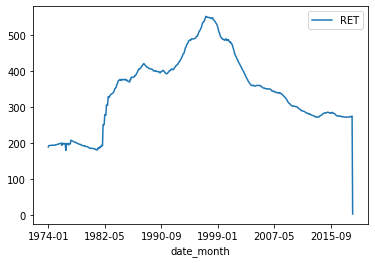

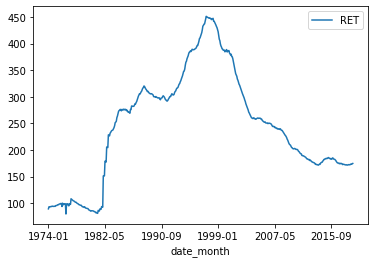

In [18]:
# justification for bin count
t = d.copy()
t = t[t['year'].between(1975,2018)]
t = t.groupby('date_month')[['RET']].count()/10
t.plot()
t = exclude_df.copy()
t = t[t['year'].between(1975,2018)]
t = t.groupby('date_month')[['RET']].count()/10
t.plot()

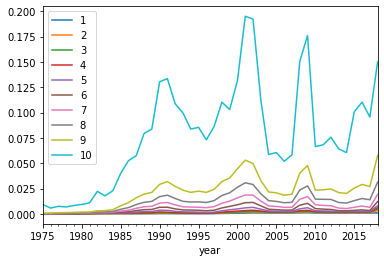

In [30]:
# explore probs per bin over time
ports_df = ports.ports.copy()
probs = pd.DataFrame()
for b in range(1,11):
    t = ports_df[ports_df.bin == b]
    probs[b] = t.groupby('year')['Prob'].mean()

probs.plot()

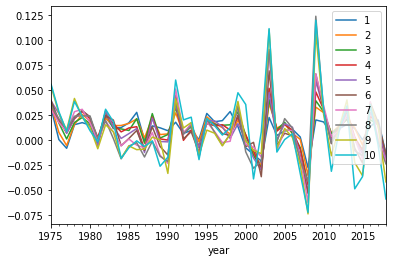

In [31]:
# explore return per bin over time
ports_df = ports.ports.copy()
returns = pd.DataFrame()
for b in range(1,11):
    t = ports_df[ports_df.bin == b]
    returns[b] = t.groupby('year')['return'].mean()

returns.plot()

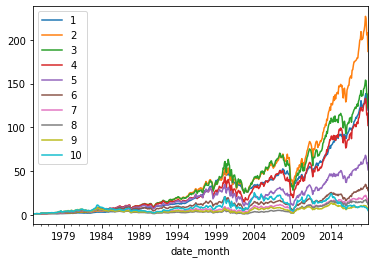

In [51]:
# explore cumulative return per bin over time
ports_df = ports.ports.copy()
cumms = pd.DataFrame()
for b in range(1,11):
    t = ports_df[ports_df.bin == b]['return'].reset_index(drop=True)
    cumm = [1]
    for i in range(t.shape[0]):
        cumm += [cumm[-1]*(1+t[i])]
    cumms[b] = cumm
    
cumms['date_month'] = pd.DataFrame(ports_df['date_month'].unique())
cumms = cumms.set_index('date_month')
cumms.iloc[:-1,].plot()

In [152]:
# explore portfolios deeper
t = tx_ports.bin_data.copy()
cols = ['NITA','TLTA','CASHMTA','EXRET','RSIZE','PRC','SIGMA','SIGMA_TLTA','financialDistress_12_periods','RET-shifted','Prob'] 
cols = ['NITA','TLTA','CASHMTA','EXRET','RSIZE','PRC','SIGMA','SIGMA_TLTA','Prob','financialDistress_12_periods'] 
t2 = t.groupby('bin')[cols].mean()#.sort_values(by='Prob')
t2['count'] = t.groupby('bin')['NITA'].count()
t2['distress count'] = t.groupby('bin')['financialDistress_12_periods'].sum()
cols = ['count','distress count','True Prob','Prob']
t2.rename(columns={'financialDistress_12_periods':'True Prob'})[cols]

,count,distress count,True Prob,Prob
bin,,,,
1,94606,247.0,0.002611,0.002354
2,94472,278.0,0.002943,0.002923
3,94451,349.0,0.003695,0.003286
4,94482,527.0,0.005578,0.003983
5,94497,635.0,0.006720,0.005839
6,94422,842.0,0.008917,0.009793
7,94453,1140.0,0.012069,0.016636
8,94480,1732.0,0.018332,0.026890
9,94443,3563.0,0.037726,0.043007
